# Lego Multiple Linear Regression Project

Flatiron Data Science course Appendix to Module 2 practice project.

In [1]:
import sqlite3

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn')

from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.model_selection import train_test_split

## Introduction 

### Problem Statement

You just got hired by Lego! 

Your first project is going to be to develop a pricing algorithm to help set a target price for new lego sets that are released to market.

### Data

Data has been provided in the form of a database.

### Methodology

In this project, we will follow the <b>O</b>btain <b>S</b>crub <b>E</b>plore <b>M</b>odel i<b>N</b>terpret - **OSEMN** framework.

## Obtain data

The data is saved as a database `lego.db`.

In [2]:
# Create a connection
conn = sqlite3.connect('datasets/lego/lego.db')

# Create a cursor
cur = conn.cursor()

In [3]:
# Investigate the database

cur.execute(''' SELECT name
                FROM sqlite_master
                WHERE type='table'
                ORDER BY name
                ;''')
results = cur.fetchall()
results

[('product_details',),
 ('product_info',),
 ('product_pricing',),
 ('product_reviews',)]

In [4]:
results[0][0]

'product_details'

In [5]:
# Preview tables by converting to Pandas DataFrames and calling head()

for item in results:
    table = item[0]
    response = cur.execute("""SELECT * 
                              FROM {} 
                              LIMIT 5
                           ;""".format(table)).fetchall()
    df = pd.DataFrame(response)
    df.columns = [x[0] for x in cur.description]
    display(df.head())

,prod_id,prod_desc,prod_long_desc,theme_name
0,630,blah,blahblah,Classic
1,2304,blah,blahblah,DUPLO®
2,7280,blah,blahblah,City
3,7281,blah,blahblah,City
4,7499,blah,blahblah,City


,prod_id,ages,piece_count,set_name
0,630,4+,1,Brick Separator
1,2304,1½-5,1,LEGO® DUPLO® Green Baseplate
2,7280,5-12,2,Straight & Crossroad Plates
3,7281,5-12,2,T-Junction & Curved Road Plates
4,7499,5-12,24,Flexible and Straight Tracks


,prod_id,country,list_price
0,75823,US,29.99
1,75822,US,19.99
2,75821,US,12.99
3,21030,US,99.99
4,21035,US,79.99


,prod_id,num_reviews,play_star_rating,review_difficulty,star_rating,val_star_rating
0,630,180,4.0,Very Easy,4.8,4.6
1,2304,15,4.4,Easy,4.0,3.3
2,7280,85,4.1,Very Easy,3.5,2.3
3,7281,40,4.1,Very Easy,3.9,2.8
4,7499,89,2.9,Easy,2.5,2.2


In [6]:
# Join the tables using prod_id 

query = """SELECT * FROM product_info
                  JOIN product_details
                  USING(prod_id)
                  JOIN product_pricing
                  USING(prod_id)
                  JOIN product_reviews
                  USING(prod_id)
                  ;"""
result = cur.execute(query).fetchall()
df = pd.DataFrame(result)
df.columns = [x[0] for x in cur.description]
display(df.head())

,prod_id,ages,piece_count,set_name,prod_desc,prod_long_desc,theme_name,country,list_price,num_reviews,play_star_rating,review_difficulty,star_rating,val_star_rating
0,75823,6-12,277,Bird Island Egg Heist,blah,blahblah,Angry Birds™,US,29.99,2.0,4.0,Average,4.5,4.0
1,75822,6-12,168,Piggy Plane Attack,blah,blahblah,Angry Birds™,US,19.99,2.0,4.0,Easy,5.0,4.0
2,75821,6-12,74,Piggy Car Escape,blah,blahblah,Angry Birds™,US,12.99,11.0,4.3,Easy,4.3,4.1
3,21030,12+,1032,United States Capitol Building,blah,blahblah,Architecture,US,99.99,23.0,3.6,Average,4.6,4.3
4,21035,12+,744,Solomon R. Guggenheim Museum®,blah,blahblah,Architecture,US,79.99,14.0,3.2,Challenging,4.6,4.1


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10870 entries, 0 to 10869
Data columns (total 14 columns):
prod_id              10870 non-null int64
ages                 10870 non-null object
piece_count          10870 non-null int64
set_name             10870 non-null object
prod_desc            10870 non-null object
prod_long_desc       10870 non-null object
theme_name           10870 non-null object
country              10870 non-null object
list_price           10870 non-null object
num_reviews          9449 non-null float64
play_star_rating     9321 non-null float64
review_difficulty    10870 non-null object
star_rating          9449 non-null float64
val_star_rating      9301 non-null float64
dtypes: float64(4), int64(2), object(8)
memory usage: 1.2+ MB


In [8]:
# Save joined tables as .csv

df.to_csv('datasets/lego/Lego_data.csv', index=False)

## Scrub data

In [9]:
df = pd.read_csv('datasets/lego/Lego_data.csv')
df.head()

,prod_id,ages,piece_count,set_name,prod_desc,prod_long_desc,theme_name,country,list_price,num_reviews,play_star_rating,review_difficulty,star_rating,val_star_rating
0,75823,6-12,277,Bird Island Egg Heist,blah,blahblah,Angry Birds™,US,29.99,2.0,4.0,Average,4.5,4.0
1,75822,6-12,168,Piggy Plane Attack,blah,blahblah,Angry Birds™,US,19.99,2.0,4.0,Easy,5.0,4.0
2,75821,6-12,74,Piggy Car Escape,blah,blahblah,Angry Birds™,US,12.99,11.0,4.3,Easy,4.3,4.1
3,21030,12+,1032,United States Capitol Building,blah,blahblah,Architecture,US,99.99,23.0,3.6,Average,4.6,4.3
4,21035,12+,744,Solomon R. Guggenheim Museum®,blah,blahblah,Architecture,US,79.99,14.0,3.2,Challenging,4.6,4.1


### Investigate Data Types

In [10]:
# Check all columns data types using info()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10870 entries, 0 to 10869
Data columns (total 14 columns):
prod_id              10870 non-null int64
ages                 10870 non-null object
piece_count          10870 non-null int64
set_name             10870 non-null object
prod_desc            10870 non-null object
prod_long_desc       10870 non-null object
theme_name           10870 non-null object
country              10870 non-null object
list_price           10870 non-null float64
num_reviews          9449 non-null float64
play_star_rating     9321 non-null float64
review_difficulty    9104 non-null object
star_rating          9449 non-null float64
val_star_rating      9301 non-null float64
dtypes: float64(5), int64(2), object(7)
memory usage: 1.2+ MB


In [11]:
# View 5 most popular unique values for each column

for col in df.columns:
    try:
        print(col, df[col].value_counts()[:5])
    except:
        print(col, df[col].value_counts())
        # If there aren't 5+ unique values for a column the first print statement
        # will throw an error for an invalid idx slice
    print('\n') # Break up the output between columns

prod_id 75531    21
76078    21
41335    21
31076    21
41311    21
Name: prod_id, dtype: int64


ages 6-12    1476
7-14    1219
8-14    1055
5-12     891
2-5      777
Name: ages, dtype: int64


piece_count 1      337
109     86
69      85
24      84
149     84
Name: piece_count, dtype: int64


set_name Chewbacca™             42
Kylo Ren™              42
Y-Wing Starfighter™    42
Rey                    42
Han Solo™              41
Name: set_name, dtype: int64


prod_desc blah    10870
Name: prod_desc, dtype: int64


prod_long_desc blahblah    10870
Name: prod_long_desc, dtype: int64


theme_name Star Wars™    1377
DUPLO®        1103
City          1072
Friends        607
Juniors        604
Name: theme_name, dtype: int64


country US    722
CA    720
NL    510
GB    510
AT    509
Name: country, dtype: int64


list_price 24.3878     565
36.5878     520
12.1878     515
18.2878     304
42.6878     234
           ... 
2.4000        1
119.9520      1
378.1878      1
731.9390      1
14.3520   

### Dealing With Null Values

In [12]:
# Count number of NaN values for each column
df.isna().sum()

prod_id                 0
ages                    0
piece_count             0
set_name                0
prod_desc               0
prod_long_desc          0
theme_name              0
country                 0
list_price              0
num_reviews          1421
play_star_rating     1549
review_difficulty    1766
star_rating          1421
val_star_rating      1569
dtype: int64

In [13]:
# View summary statistics
df.describe()

,prod_id,piece_count,list_price,num_reviews,play_star_rating,star_rating,val_star_rating
count,1.087000e+04,10870.000000,10870.000000,9449.000000,9321.000000,9449.000000,9301.000000
mean,6.181634e+04,503.936431,67.309137,17.813737,4.355413,4.510319,4.214439
std,1.736390e+05,831.209318,94.669414,38.166693,0.617272,0.516463,0.670906
min,6.300000e+02,1.000000,2.272400,1.000000,1.000000,1.800000,1.000000
25%,2.112300e+04,97.000000,21.899000,2.000000,4.000000,4.300000,4.000000
50%,4.207350e+04,223.000000,36.587800,6.000000,4.500000,4.600000,4.300000
75%,7.124800e+04,556.000000,73.187800,14.000000,4.800000,5.000000,4.700000
max,2.000431e+06,7541.000000,1104.870000,367.000000,5.000000,5.000000,5.000000


Given that most of the features with null values concern user reviews of the lego set, it is reasonable to wonder whether there is strong correlation between these features in the first place. Let us investigate this hypothesis.

In [14]:
# Investigate whether multicollinearity exists between the review features 
feats = ['num_reviews', 'play_star_rating', 'star_rating', 'val_star_rating']
df[feats].corr()

,num_reviews,play_star_rating,star_rating,val_star_rating
num_reviews,1.000000,-0.060884,0.004541,0.026664
play_star_rating,-0.060884,1.000000,0.619246,0.484341
star_rating,0.004541,0.619246,1.000000,0.731538
val_star_rating,0.026664,0.484341,0.731538,1.000000


There is substantial correlation between the `play_star_rating`, `star_rating` and `val_star_rating`. While this could lead to multicollinearity in your eventual regression model, it is too early to clearly determine this at this point.

We could use these features to help impute missing values in the others features. For example, where we are missing the `star_rating` for a particular entry but have the `val_star_rating` for that same entry, it seems reasonable to assume that it is a good estimate for the missing `star_rating` value as they are highly correlated. However, doing so does come with risks; as we would be further increasing the correlation between these features we could further provoke multicollinearity in the final model.

In [15]:
print('Number missing all three:',
      len(df[(df.play_star_rating.isnull())
              & (df.star_rating.isnull())
              & (df.val_star_rating.isnull())
            ])
     )

Number missing all three: 1421


It seems like when one of these features is missing, the other two are also likely to be missing.

Let us fill the missing values with the median where possible (`num_reviews`, `play_star_rating`, `star_rating`, `val_star_rating`) and 'unknown' for `review_difficulty`.

In [16]:
# Fill NaN with median where possible using try/except
for col in df.columns:
    try:
        median = df[col].median()
        df[col] = df[col].fillna(value=median)
    except:
        continue

In [17]:
# Fill NaN in review_difficulty column with unknown
df.review_difficulty = df.review_difficulty.fillna('unknown')

In [18]:
# Check no more missing values
df.isna().sum()

prod_id              0
ages                 0
piece_count          0
set_name             0
prod_desc            0
prod_long_desc       0
theme_name           0
country              0
list_price           0
num_reviews          0
play_star_rating     0
review_difficulty    0
star_rating          0
val_star_rating      0
dtype: int64

### Checking For Multicollinearity

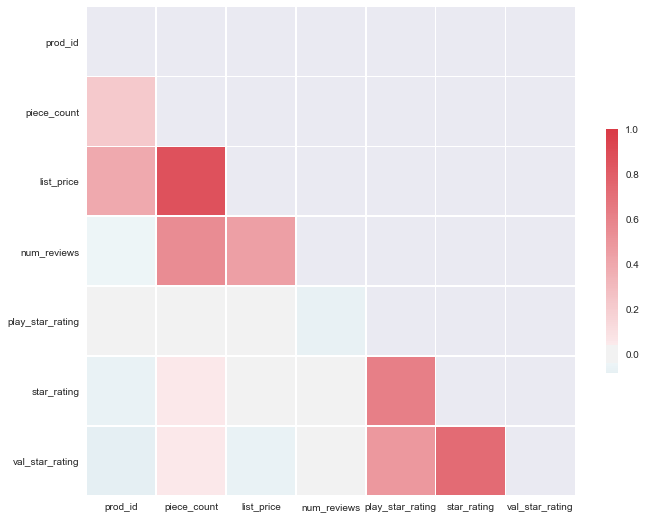

In [19]:
# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

### Normalisation

The most common form of data normalization is by converting data to z-scores. This is commonly referred to as standardization.

$$ \Large z= \dfrac{x-\mu}{\sigma}$$

$$ \large \mu = \text{Mean}$$
$$ \large \sigma = \text{Standard Deviation}$$

In [20]:
# Define function for standardising

def std_col(series):
    ''' Converts series into z-score/ standardisation'''
    return (series - np.mean(series))/ np.std(series)

In [21]:
# Apply function to numeric columns (except price)
for col in ['piece_count', 'num_reviews', 'play_star_rating', 'star_rating', 'val_star_rating']:
    df[col] = std_col(df[col])

In [22]:
# Check results using describe()
df.describe().round(3)

,prod_id,piece_count,list_price,num_reviews,play_star_rating,star_rating,val_star_rating
count,10870.000,10870.000,10870.000,10870.000,10870.000,10870.000,10870.000
mean,61816.344,0.000,67.309,0.000,0.000,-0.000,0.000
std,173638.990,1.000,94.669,1.000,1.000,1.000,1.000
min,630.000,-0.605,2.272,-0.426,-5.884,-5.642,-5.194
25%,21123.000,-0.490,21.899,-0.371,-0.481,-0.460,-0.365
50%,42073.500,-0.338,36.588,-0.287,0.216,0.162,0.118
75%,71248.000,0.063,73.188,-0.119,0.565,0.783,0.601
max,2000431.000,8.466,1104.870,9.796,1.087,0.991,1.245


Let us save the 'cleaned' DataFrame before dealing with categorical variables and one-hot encoding.

In [23]:
# Save to csv
df.to_csv('datasets/lego/Lego_cleaned.csv', index = False)

### One-Hot Encoding of Categorical Variables

Let us deal with the categorical columns by one-hot encoding them using the `pd.get_dummies()` function.

In [24]:
# Obtain all columns
df.columns

Index(['prod_id', 'ages', 'piece_count', 'set_name', 'prod_desc',
       'prod_long_desc', 'theme_name', 'country', 'list_price', 'num_reviews',
       'play_star_rating', 'review_difficulty', 'star_rating',
       'val_star_rating'],
      dtype='object')

In [25]:
# Choose appropriate columns for one-hot encoding
onehotcols = ['ages', 'theme_name', 'country', 'review_difficulty']

In [26]:
# Create DataFrame with above columns
dfonehot = df[onehotcols]

# Get dummy variables and drop first one to not create dependency
dfonehot = pd.get_dummies(dfonehot, drop_first = True)

In [27]:
dfonehot.head()

,ages_10-14,ages_10-16,ages_10-21,ages_11-16,ages_12+,ages_12-16,ages_14+,ages_16+,ages_1½-3,ages_1½-5,...,country_NO,country_NZ,country_PL,country_PT,country_US,review_difficulty_Challenging,review_difficulty_Easy,review_difficulty_Very Challenging,review_difficulty_Very Easy,review_difficulty_unknown
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0


In [28]:
# Recreate DataFrame with one-hot encoded variables
df_withonehot = pd.concat([df,dfonehot], axis=1)
df_withonehot.head()

,prod_id,ages,piece_count,set_name,prod_desc,prod_long_desc,theme_name,country,list_price,num_reviews,...,country_NO,country_NZ,country_PL,country_PT,country_US,review_difficulty_Challenging,review_difficulty_Easy,review_difficulty_Very Challenging,review_difficulty_Very Easy,review_difficulty_unknown
0,75823,6-12,-0.273032,Bird Island Egg Heist,blah,blahblah,Angry Birds™,US,29.99,-0.398531,...,0,0,0,0,1,0,0,0,0,0
1,75822,6-12,-0.404172,Piggy Plane Attack,blah,blahblah,Angry Birds™,US,19.99,-0.398531,...,0,0,0,0,1,0,1,0,0,0
2,75821,6-12,-0.517266,Piggy Car Escape,blah,blahblah,Angry Birds™,US,12.99,-0.147169,...,0,0,0,0,1,0,1,0,0,0
3,21030,12+,0.635325,United States Capitol Building,blah,blahblah,Architecture,US,99.99,0.187981,...,0,0,0,0,1,0,0,0,0,0
4,21035,12+,0.288826,Solomon R. Guggenheim Museum®,blah,blahblah,Architecture,US,79.99,-0.063381,...,0,0,0,0,1,1,0,0,0,0


In [29]:
# Drop columns where we have done one-hot encoding
df_withonehot = df_withonehot.drop(onehotcols, axis = 1)
df_withonehot.head()

,prod_id,piece_count,set_name,prod_desc,prod_long_desc,list_price,num_reviews,play_star_rating,star_rating,val_star_rating,...,country_NO,country_NZ,country_PL,country_PT,country_US,review_difficulty_Challenging,review_difficulty_Easy,review_difficulty_Very Challenging,review_difficulty_Very Easy,review_difficulty_unknown
0,75823,-0.273032,Bird Island Egg Heist,blah,blahblah,29.99,-0.398531,-0.655309,-0.045689,-0.365027,...,0,0,0,0,1,0,0,0,0,0
1,75822,-0.404172,Piggy Plane Attack,blah,blahblah,19.99,-0.398531,-0.655309,0.990697,-0.365027,...,0,0,0,0,1,0,1,0,0,0
2,75821,-0.517266,Piggy Car Escape,blah,blahblah,12.99,-0.147169,-0.132479,-0.460243,-0.204073,...,0,0,0,0,1,0,1,0,0,0
3,21030,0.635325,United States Capitol Building,blah,blahblah,99.99,0.187981,-1.352415,0.161588,0.117836,...,0,0,0,0,1,0,0,0,0,0
4,21035,0.288826,Solomon R. Guggenheim Museum®,blah,blahblah,79.99,-0.063381,-2.049521,0.161588,-0.204073,...,0,0,0,0,1,1,0,0,0,0


In [30]:
# Save data with one-hot encoding
df_withonehot.to_csv('datasets/lego/lego_with_one_hot_encoding.csv', index = False)

## Explore data

In this section we'll perform exploratory data analysis (EDA) to gain insights into the data. We'll investigate the distributions of some of the various features and their relationship with the target variable: `list_price`.

We will start with the cleaned DataFrame, one step prior to one-hot encoding.

In [31]:
df.head()

,prod_id,ages,piece_count,set_name,prod_desc,prod_long_desc,theme_name,country,list_price,num_reviews,play_star_rating,review_difficulty,star_rating,val_star_rating
0,75823,6-12,-0.273032,Bird Island Egg Heist,blah,blahblah,Angry Birds™,US,29.99,-0.398531,-0.655309,Average,-0.045689,-0.365027
1,75822,6-12,-0.404172,Piggy Plane Attack,blah,blahblah,Angry Birds™,US,19.99,-0.398531,-0.655309,Easy,0.990697,-0.365027
2,75821,6-12,-0.517266,Piggy Car Escape,blah,blahblah,Angry Birds™,US,12.99,-0.147169,-0.132479,Easy,-0.460243,-0.204073
3,21030,12+,0.635325,United States Capitol Building,blah,blahblah,Architecture,US,99.99,0.187981,-1.352415,Average,0.161588,0.117836
4,21035,12+,0.288826,Solomon R. Guggenheim Museum®,blah,blahblah,Architecture,US,79.99,-0.063381,-2.049521,Challenging,0.161588,-0.204073


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10870 entries, 0 to 10869
Data columns (total 14 columns):
prod_id              10870 non-null int64
ages                 10870 non-null object
piece_count          10870 non-null float64
set_name             10870 non-null object
prod_desc            10870 non-null object
prod_long_desc       10870 non-null object
theme_name           10870 non-null object
country              10870 non-null object
list_price           10870 non-null float64
num_reviews          10870 non-null float64
play_star_rating     10870 non-null float64
review_difficulty    10870 non-null object
star_rating          10870 non-null float64
val_star_rating      10870 non-null float64
dtypes: float64(6), int64(1), object(7)
memory usage: 1.2+ MB


In [33]:
df.describe().round(3)

,prod_id,piece_count,list_price,num_reviews,play_star_rating,star_rating,val_star_rating
count,10870.000,10870.000,10870.000,10870.000,10870.000,10870.000,10870.000
mean,61816.344,0.000,67.309,0.000,0.000,-0.000,0.000
std,173638.990,1.000,94.669,1.000,1.000,1.000,1.000
min,630.000,-0.605,2.272,-0.426,-5.884,-5.642,-5.194
25%,21123.000,-0.490,21.899,-0.371,-0.481,-0.460,-0.365
50%,42073.500,-0.338,36.588,-0.287,0.216,0.162,0.118
75%,71248.000,0.063,73.188,-0.119,0.565,0.783,0.601
max,2000431.000,8.466,1104.870,9.796,1.087,0.991,1.245


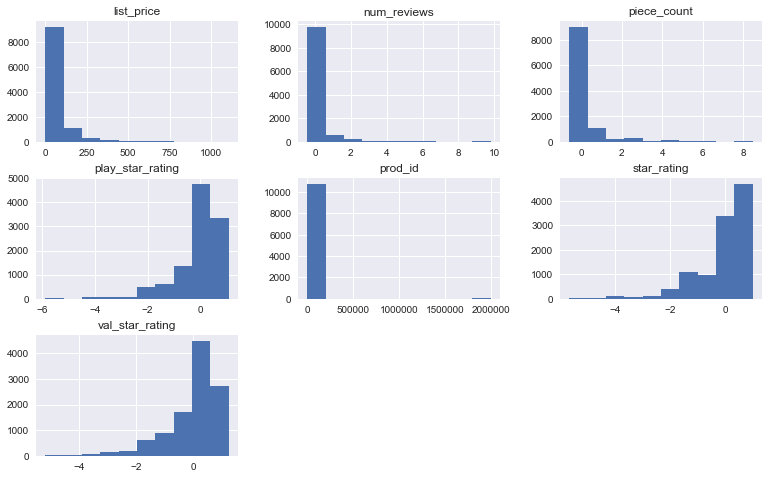

In [34]:
# Plot histograms for all the numeric variables

df.hist(figsize = (13,8))
plt.show()

We note that the distributions appear heavily skewed.

### Investigate Linearity

As one assumption in linear regression is that the target variable is linearly related to the input features, let us investigate linearity.

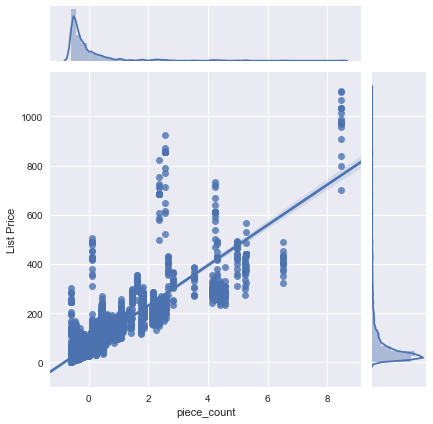

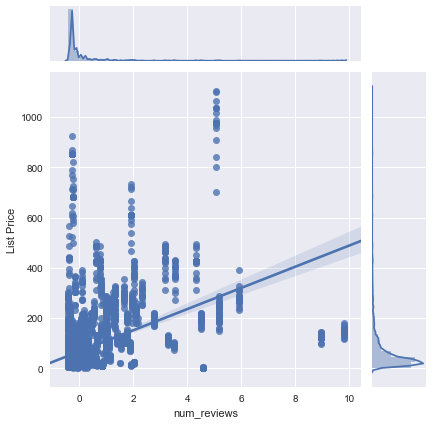

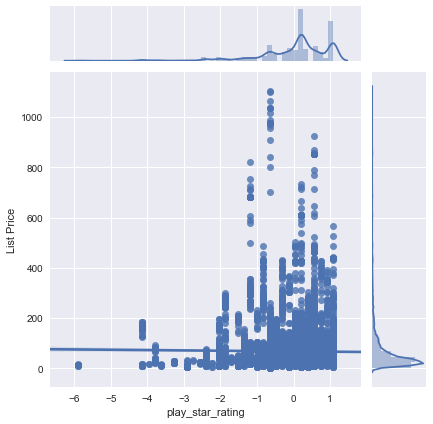

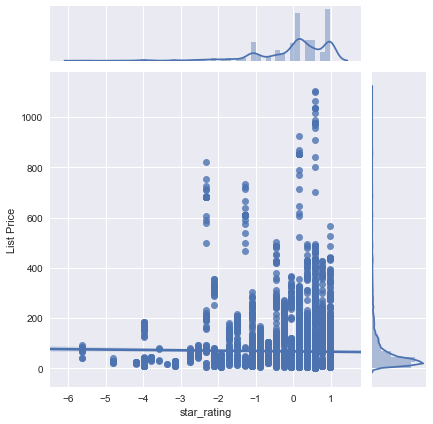

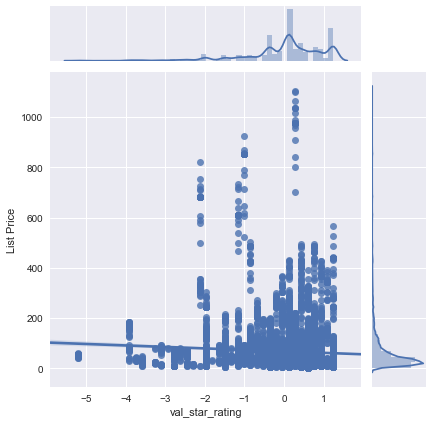

In [35]:
# Use jointplot to plot scatterplot with linear regression line for features against list price

# Define cols with numeric values
relcols = ['piece_count', 'num_reviews', 'play_star_rating', 'star_rating', 'val_star_rating']

for col in relcols:
    sns.jointplot(x = df[col], y = df['list_price'], data = df, kind = 'reg')
    plt.ylabel('List Price')
    plt.show()

Comments:

- `piece_count` appears to have a linear relationship with `list_price`
- `num_reviews` has somewhat of a linear relationship with `list_price`
- `play_star_rating`, `star_rating` and `val_star_rating` do not appear to have a linear relationship with `list_price`

### Investigate multicollinearity

While definitive checks for multicollinearity require analyzing the resulting model, predictors with overly high pairwise-correlation (r > .65) are almost certain to produce multicollinearity in a model. Let us generate the pairwise (pearson) correlation coefficients of our predictive features and visualize these coefficients as a heatmap.

In [36]:
# Use same relcols as defined for linearity (ie numeric values excluding target)

corr = df[relcols].corr()
corr

,piece_count,num_reviews,play_star_rating,star_rating,val_star_rating
piece_count,1.000000,0.548783,-0.023281,0.055481,0.057313
num_reviews,0.548783,1.000000,-0.070892,-0.002466,0.020471
play_star_rating,-0.023281,-0.070892,1.000000,0.619044,0.485843
star_rating,0.055481,-0.002466,0.619044,1.000000,0.728203
val_star_rating,0.057313,0.020471,0.485843,0.728203,1.000000


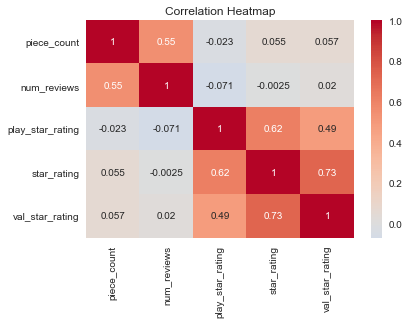

In [37]:
# Plot heatmap
sns.heatmap(corr, center = 0, annot = True, cmap = 'coolwarm')
plt.title('Correlation Heatmap')
plt.show()

The rating features show little promise for adding predictive power towards the `list_price`. This diminishes worry concerning their high correlation. That said, the two most promising predictors: `piece_count` and `num_reviews` also display fairly high correlation. Further analysis of an initial model will clearly be warranted.

## Model data

Start with our DataFrame with one-hot encoding of categorical variables.

### Base model

In [38]:
df = df_withonehot

In [39]:
df = df.drop(['set_name', 'prod_desc', 'prod_long_desc'], axis = 1)
df.head()

,prod_id,piece_count,list_price,num_reviews,play_star_rating,star_rating,val_star_rating,ages_10-14,ages_10-16,ages_10-21,...,country_NO,country_NZ,country_PL,country_PT,country_US,review_difficulty_Challenging,review_difficulty_Easy,review_difficulty_Very Challenging,review_difficulty_Very Easy,review_difficulty_unknown
0,75823,-0.273032,29.99,-0.398531,-0.655309,-0.045689,-0.365027,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,75822,-0.404172,19.99,-0.398531,-0.655309,0.990697,-0.365027,0,0,0,...,0,0,0,0,1,0,1,0,0,0
2,75821,-0.517266,12.99,-0.147169,-0.132479,-0.460243,-0.204073,0,0,0,...,0,0,0,0,1,0,1,0,0,0
3,21030,0.635325,99.99,0.187981,-1.352415,0.161588,0.117836,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,21035,0.288826,79.99,-0.063381,-2.049521,0.161588,-0.204073,0,0,0,...,0,0,0,0,1,1,0,0,0,0


We need to manipulate the column names as Statsmodels does not allow spaces, apostrophe or arithmetic symbols (+) in column names. 

In [40]:
# Define substitions of special symbols
subs = [(' ', '_'),('.',''),("'",""),('™', ''), ('®',''),
        ('+','plus'), ('½','half'), ('-','_')
       ]

In [41]:
# Define function to format column names
def col_formatting(col):
    '''Takes a column name and replaces special symbols according to subs'''
    for old, new in subs:
        col = col.replace(old,new)
    return col

In [42]:
# Apply col_formatting function to df.columns
df.columns = [col_formatting(col) for col in df.columns]

In [43]:
# Define target and features
y = df['list_price']
X = df.drop('list_price', axis = 1)

In [44]:
# Split into training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [45]:
# Fit model onto training set
X_int = sm.add_constant(X_train)
model = sm.OLS(y_train,X_int).fit()
model.summary()

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             list_price   R-squared:                       0.861
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                     561.1
Date:                Fri, 15 May 2020   Prob (F-statistic):               0.00
Time:                        10:12:53   Log-Likelihood:                -43324.
No. Observations:                8696   AIC:                         8.684e+04
Df Residuals:                    8600   BIC:                         8.752e+04
Df Model:                          95                                         
Covariance Type:            nonrobust                                         
====================================================================================================================
                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
const                                              215.7524     22.093      9.766      0.000     172.444     259.060
prod_id                                           1.973e-05   3.08e-05      0.641      0.522   -4.06e-05    8.01e-05
piece_count                                         75.1386      0.883     85.115      0.000      73.408      76.869
num_reviews                                          6.6755      0.681      9.808      0.000       5.341       8.010
play_star_rating                                     5.0782      0.614      8.273      0.000       3.875       6.281
star_rating                                         -0.8278      0.694     -1.192      0.233      -2.189       0.534
val_star_rating                                     -9.0144      0.623    -14.463      0.000     -10.236      -7.793
ages_10_14                                        -144.3478     11.286    -12.790      0.000    -166.471    -122.225
ages_10_16                                        -132.1118      8.348    -15.826      0.000    -148.476    -115.748
ages_10_21                                         -61.2531      5.789    -10.580      0.000     -72.602     -49.904
ages_11_16                                        -133.5250      9.440    -14.144      0.000    -152.030    -115.020
ages_12plus                                        -53.6476      7.368     -7.282      0.000     -68.090     -39.205
ages_12_16                                        -168.7058     10.041    -16.802      0.000    -188.388    -149.024
ages_14plus                                        -99.8523      8.141    -12.265      0.000    -115.811     -83.893
ages_16plus                                        -92.9904      9.538     -9.750      0.000    -111.687     -74.294
ages_1half_3                                       -42.6356      5.955     -7.160      0.000     -54.308     -30.963
ages_1half_5                                       -38.2105      6.313     -6.052      0.000     -50.586     -25.835
ages_2_5                                           -18.5364      5.728     -3.236      0.001     -29.765      -7.308
ages_4plus                                         -64.3570      9.560     -6.732      0.000     -83.096     -45.617
ages_4_7                                           -50.7469      7.943     -6.389      0.000     -66.316     -35.178
ages_4_99                                          -47.2417      7.968     -5.929      0.000     -62.861     -31.622
ages_5plus                                         -77.8197     11.354     -6.854      0.000    -100.077     -55.563
ages_5_12                                         -156.0118      7.881    -19.796      0.000    -171.460    -140.563
ages_5_8                                 

Good $R^2$ but note number of features have high p-value and therefore not statistically relevant.

### Select statistically significant features

We will choose to remove features where the p-value is greater than 0.05 as we only want statistically significant results.

In [46]:
summary = model.summary()
p_table = summary.tables[1]

# Make a dataframe using first table (p_table)
p_table_df = pd.DataFrame(p_table.data)
p_table_df.head()

,0,1,2,3,4,5,6
0,,coef,std err,t,P>|t|,[0.025,0.975]
1,const,215.7524,22.093,9.766,0.000,172.444,259.060
2,prod_id,1.973e-05,3.08e-05,0.641,0.522,-4.06e-05,8.01e-05
3,piece_count,75.1386,0.883,85.115,0.000,73.408,76.869
4,num_reviews,6.6755,0.681,9.808,0.000,5.341,8.010


In [47]:
# Define columns as first row
p_table_df.columns = p_table_df.iloc[0]
p_table_df.columns

Index(['', 'coef', 'std err', 't', 'P>|t|', '[0.025', '0.975]'], dtype='object', name=0)

In [48]:
# Drop first row
p_table_df = p_table_df.drop(0)
p_table_df.head()

,,coef,std err,t,P>|t|,[0.025,0.975]
1,const,215.7524,22.093,9.766,0.000,172.444,259.060
2,prod_id,1.973e-05,3.08e-05,0.641,0.522,-4.06e-05,8.01e-05
3,piece_count,75.1386,0.883,85.115,0.000,73.408,76.869
4,num_reviews,6.6755,0.681,9.808,0.000,5.341,8.010
5,play_star_rating,5.0782,0.614,8.273,0.000,3.875,6.281


In [49]:
p_table_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 1 to 100
Data columns (total 7 columns):
           100 non-null object
coef       100 non-null object
std err    100 non-null object
t          100 non-null object
P>|t|      100 non-null object
[0.025     100 non-null object
0.975]     100 non-null object
dtypes: object(7)
memory usage: 6.2+ KB


In [50]:
# Convert p-value to float to be able to compare to alpha
p_table_df['P>|t|'] = p_table_df['P>|t|'].astype(float)

In [51]:
# Identify features with p-value < 0.05
low_p = p_table_df[p_table_df['P>|t|'] <0.05]
low_p.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56 entries, 1 to 100
Data columns (total 7 columns):
           56 non-null object
coef       56 non-null object
std err    56 non-null object
t          56 non-null object
P>|t|      56 non-null float64
[0.025     56 non-null object
0.975]     56 non-null object
dtypes: float64(1), object(6)
memory usage: 3.5+ KB


In [52]:
low_p.head()

,,coef,std err,t,P>|t|,[0.025,0.975]
1,const,215.7524,22.093,9.766,0.0,172.444,259.060
3,piece_count,75.1386,0.883,85.115,0.0,73.408,76.869
4,num_reviews,6.6755,0.681,9.808,0.0,5.341,8.010
5,play_star_rating,5.0782,0.614,8.273,0.0,3.875,6.281
7,val_star_rating,-9.0144,0.623,-14.463,0.0,-10.236,-7.793


In [53]:
feats = list(low_p.iloc[:,0])
feats.remove('const')
feats[:10]

['piece_count',
 'num_reviews',
 'play_star_rating',
 'val_star_rating',
 'ages_10_14',
 'ages_10_16',
 'ages_10_21',
 'ages_11_16',
 'ages_12plus',
 'ages_12_16']

In [54]:
len(feats)

55

Let us now build a new model using these features.

In [55]:
X_train = X_train[feats]

In [56]:
# Fit model onto training set
X_int = sm.add_constant(X_train)
model = sm.OLS(y_train,X_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             list_price   R-squared:                       0.855
Model:                            OLS   Adj. R-squared:                  0.854
Method:                 Least Squares   F-statistic:                     997.4
Date:                Fri, 15 May 2020   Prob (F-statistic):               0.00
Time:                        10:12:53   Log-Likelihood:                -43517.
No. Observations:                8696   AIC:                         8.714e+04
Df Residuals:                    8644   BIC:                         8.751e+04
Df Model:                          51                                         
Covariance Type:            nonrobust                                         
====================================================================================================================
                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
const                                              190.2846      4.705     40.440      0.000     181.061     199.508
piece_count                                         76.0133      0.869     87.519      0.000      74.311      77.716
num_reviews                                          7.6935      0.659     11.679      0.000       6.402       8.985
play_star_rating                                     5.0356      0.521      9.672      0.000       4.015       6.056
val_star_rating                                    -10.6226      0.487    -21.824      0.000     -11.577      -9.669
ages_10_14                                        -111.2518      9.699    -11.471      0.000    -130.263     -92.240
ages_10_16                                        -114.5014      5.751    -19.909      0.000    -125.775    -103.228
ages_10_21                                         -65.9491      5.597    -11.782      0.000     -76.921     -54.977
ages_11_16                                        -120.5719      7.060    -17.078      0.000    -134.411    -106.733
ages_12plus                                        -47.1401      6.326     -7.452      0.000     -59.541     -34.739
ages_12_16                                        -153.8687      8.179    -18.812      0.000    -169.902    -137.835
ages_14plus                                        -78.1032      5.886    -13.270      0.000     -89.641     -66.566
ages_16plus                                        -82.5454      7.846    -10.520      0.000     -97.926     -67.165
ages_1half_3                                       -35.3191      2.602    -13.573      0.000     -40.420     -30.218
ages_1half_5                                       -32.4455      3.369     -9.631      0.000     -39.049     -25.842
ages_2_5                                           -11.5444      2.019     -5.716      0.000     -15.503      -7.586
ages_4plus                                         -59.3745      6.304     -9.418      0.000     -71.732     -47.017
ages_4_7                                           -43.4110      3.515    -12.352      0.000     -50.300     -36.522
ages_4_99                                          -36.5211      3.597    -10.154      0.000     -43.571     -29.471
ages_5plus                                         -64.9495      3.775    -17.205      0.000     -72.350     -57.549
ages_5_12                                         -124.0349      4.874    -25.451      0.000    -133.588    -114.482
ages_5_8                                           -26.6035      5.862     -4.538      0.000     -38.095     -15.112
ages_6plus                                        -128.3361      6.824    -18.806      0.000    -141.713    -114.959
ages_6_12                                

### Deal with multicollinearity

We will explore the Variance Inflation Factor.

In [57]:
X = X_train[feats]

vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_results = list(zip(X_train.columns, vif))
vif_results

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


[('piece_count', 4.977452847865191),
 ('num_reviews', 2.7393844147210693),
 ('play_star_rating', 1.792681732540211),
 ('val_star_rating', 1.5468247711787522),
 ('ages_10_14', 1.051524964619614),
 ('ages_10_16', 1.0648090812272),
 ('ages_10_21', 1.167525918884546),
 ('ages_11_16', 1.1344379916520508),
 ('ages_12plus', 5.341866592396993),
 ('ages_12_16', 1.1373551596857785),
 ('ages_14plus', 1.7626976519293027),
 ('ages_16plus', 9.7909212925326),
 ('ages_1half_3', inf),
 ('ages_1half_5', inf),
 ('ages_2_5', inf),
 ('ages_4plus', inf),
 ('ages_4_7', inf),
 ('ages_4_99', inf),
 ('ages_5plus', inf),
 ('ages_5_12', 1.4946888955593498),
 ('ages_5_8', inf),
 ('ages_6plus', 2.382141665286787),
 ('ages_6_12', 1.4850191761121658),
 ('ages_6_14', 1.1780235088299906),
 ('ages_7plus', 1.0101179084175285),
 ('ages_7_12', 1.3125962776441276),
 ('ages_7_14', 1.488089277982783),
 ('ages_8plus', 1.089998979179762),
 ('ages_8_12', 1.1115328755656677),
 ('ages_8_14', 1.1940461061518828),
 ('ages_9_12', 1.0

We will choose to keep features with vif less than 5.

In [58]:
feats = [feat for feat, result in vif_results if result < 5]
len(feats)

41

In [59]:
# Redefine X_train taking only feats columns
X_train = X_train[feats]

In [60]:
# Fit model onto training set
X_int = sm.add_constant(X_train)
model = sm.OLS(y_train,X_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             list_price   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     1116.
Date:                Fri, 15 May 2020   Prob (F-statistic):               0.00
Time:                        10:12:54   Log-Likelihood:                -43913.
No. Observations:                8696   AIC:                         8.791e+04
Df Residuals:                    8654   BIC:                         8.821e+04
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
====================================================================================================================
                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
const                                               88.8124      1.328     66.874      0.000      86.209      91.416
piece_count                                         77.2412      0.668    115.687      0.000      75.932      78.550
num_reviews                                          5.0509      0.602      8.388      0.000       3.871       6.231
play_star_rating                                     5.2550      0.539      9.741      0.000       4.198       6.313
val_star_rating                                    -11.8579      0.504    -23.548      0.000     -12.845     -10.871
ages_10_14                                         -19.4804      9.156     -2.128      0.033     -37.429      -1.532
ages_10_16                                         -15.7569      3.715     -4.242      0.000     -23.038      -8.476
ages_10_21                                          38.5426      3.302     11.673      0.000      32.070      45.015
ages_11_16                                         -24.9237      5.519     -4.516      0.000     -35.741     -14.106
ages_12_16                                         -58.1513      6.889     -8.442      0.000     -71.654     -44.648
ages_14plus                                         13.4215      3.601      3.727      0.000       6.363      20.480
ages_5_12                                          -19.4600      1.723    -11.293      0.000     -22.838     -16.082
ages_6plus                                         -25.0422      5.314     -4.713      0.000     -35.459     -14.626
ages_6_12                                          -18.1188      1.503    -12.053      0.000     -21.066     -15.172
ages_6_14                                          -23.5932      3.239     -7.284      0.000     -29.942     -17.244
ages_7plus                                          -6.8905     26.878     -0.256      0.798     -59.577      45.796
ages_7_12                                          -14.9276      1.891     -7.894      0.000     -18.635     -11.221
ages_7_14                                          -18.1340      1.583    -11.452      0.000     -21.238     -15.030
ages_8plus                                         -11.3825      2.989     -3.808      0.000     -17.242      -5.523
ages_8_12                                          -21.0260      2.624     -8.013      0.000     -26.170     -15.882
ages_8_14                                          -15.9122      1.675     -9.498      0.000     -19.196     -12.628
ages_9_12                                          -36.1068      6.177     -5.845      0.000     -48.215     -23.999
ages_9_14                                          -16.2123      2.267     -7.151      0.000     -20.656     -11.768
ages_9_16                                

### Check normality

Investigate if residuals are normally distributed.

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  This is separate from the ipykernel package so we can avoid doing imports until


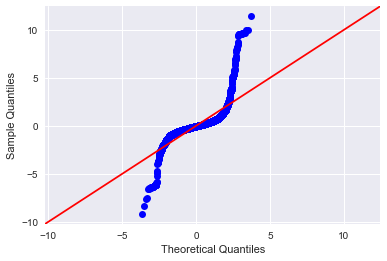

In [61]:
residuals = model.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
fig.show()

### Check homoscedasticity

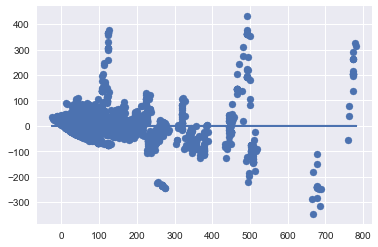

In [62]:
# Plot scatterplot of residuals 
plt.scatter(model.predict(X_int), model.resid)
plt.plot(model.predict(X_int), [0 for i in range(len(X_train))])
plt.show()

This displays a fairly pronounced 'funnel' shape: errors appear to increase as the list_price increases. This doesn't bode well for our model. Subsetting the data to remove outliers and confining the model to this restricted domain may be necessary. A log transformation or something equivalent may also be appropriate.

### Further refinements

We will look to remove outliers as it appears that these are having a substantial impact on the model.

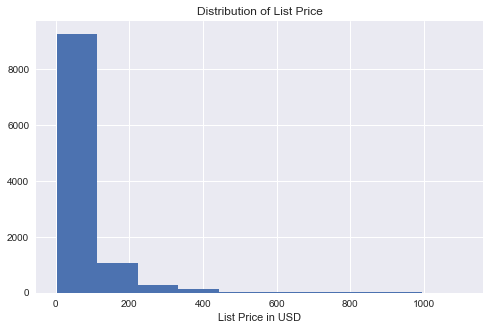

In [63]:
df['list_price'].hist(figsize = (8,5))
plt.title('Distribution of List Price')
plt.xlabel('List Price in USD')
plt.show()

In [64]:
df['list_price'].quantile(q = 0.2)

18.2878

In [65]:
# Look at 0.9 percentile
for i in range (90,100):
    q = i/100
    quantile = df['list_price'].quantile(q = q)
    print(f'{q} percentile: {round(quantile,3)}')

0.9 percentile: 143.952
0.91 percentile: 153.986
0.92 percentile: 170.788
0.93 percentile: 182.988
0.94 percentile: 198.793
0.95 percentile: 220.03
0.96 percentile: 251.905
0.97 percentile: 292.788
0.98 percentile: 359.88
0.99 percentile: 463.588


In [66]:
# Choose to remove values with list_price above 450.
df = df[df['list_price']<450]

In [67]:
# Apply log transform to list_price
df['list_price'] = df['list_price'].map(lambda x: np.log(x))

In [68]:
# Define target and features
y = df['list_price']
X = df.drop('list_price', axis = 1)

In [69]:
# Split into training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [70]:
# Subset features
X_train = X_train[feats]

In [71]:
# Fit model onto training set
X_int = sm.add_constant(X_train)
model = sm.OLS(y_train,X_int).fit()
model.summary()

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             list_price   R-squared:                       0.733
Model:                            OLS   Adj. R-squared:                  0.732
Method:                 Least Squares   F-statistic:                     574.0
Date:                Fri, 15 May 2020   Prob (F-statistic):               0.00
Time:                        10:12:55   Log-Likelihood:                -5655.0
No. Observations:                8604   AIC:                         1.139e+04
Df Residuals:                    8562   BIC:                         1.169e+04
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
====================================================================================================================
                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
const                                                3.8371      0.017    230.414      0.000       3.804       3.870
piece_count                                          0.5814      0.010     59.907      0.000       0.562       0.600
num_reviews                                         -0.0278      0.007     -3.736      0.000      -0.042      -0.013
play_star_rating                                     0.1024      0.007     15.135      0.000       0.089       0.116
val_star_rating                                     -0.1713      0.006    -27.232      0.000      -0.184      -0.159
ages_10_14                                           0.5134      0.116      4.409      0.000       0.285       0.742
ages_10_16                                           0.6773      0.047     14.464      0.000       0.585       0.769
ages_10_21                                           0.6281      0.040     15.562      0.000       0.549       0.707
ages_11_16                                           0.3760      0.069      5.461      0.000       0.241       0.511
ages_12_16                                           0.1388      0.084      1.659      0.097      -0.025       0.303
ages_14plus                                          0.6651      0.049     13.674      0.000       0.570       0.760
ages_5_12                                           -0.1467      0.021     -6.945      0.000      -0.188      -0.105
ages_6plus                                          -0.6829      0.065    -10.578      0.000      -0.809      -0.556
ages_6_12                                            0.0289      0.019      1.559      0.119      -0.007       0.065
ages_6_14                                           -0.6227      0.040    -15.662      0.000      -0.701      -0.545
ages_7plus                                           0.2468      0.469      0.526      0.599      -0.673       1.167
ages_7_12                                            0.2382      0.023     10.247      0.000       0.193       0.284
ages_7_14                                            0.0188      0.020      0.958      0.338      -0.020       0.057
ages_8plus                                           0.4268      0.037     11.581      0.000       0.355       0.499
ages_8_12                                            0.3375      0.032     10.396      0.000       0.274       0.401
ages_8_14                                            0.3660      0.021     17.541      0.000       0.325       0.407
ages_9_12                                            0.2973      0.084      3.533      0.000       0.132       0.462
ages_9_14                                            0.5495      0.029     18.967      0.000       0.493       0.606
ages_9_16                                

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  after removing the cwd from sys.path.


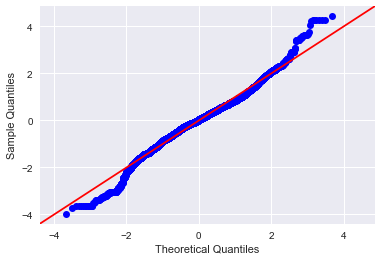

In [72]:
# Recheck normality
residuals = model.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
fig.show()

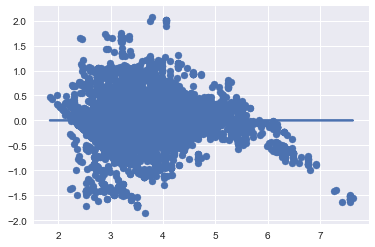

In [73]:
# Recheck homoscedasticity

plt.scatter(model.predict(X_int), model.resid)
plt.plot(model.predict(X_int), [0 for i in range(len(X_train))])
plt.show()

Normality assumption and homoscedacity assumption are better met.

Checks for `piece_count` feature.

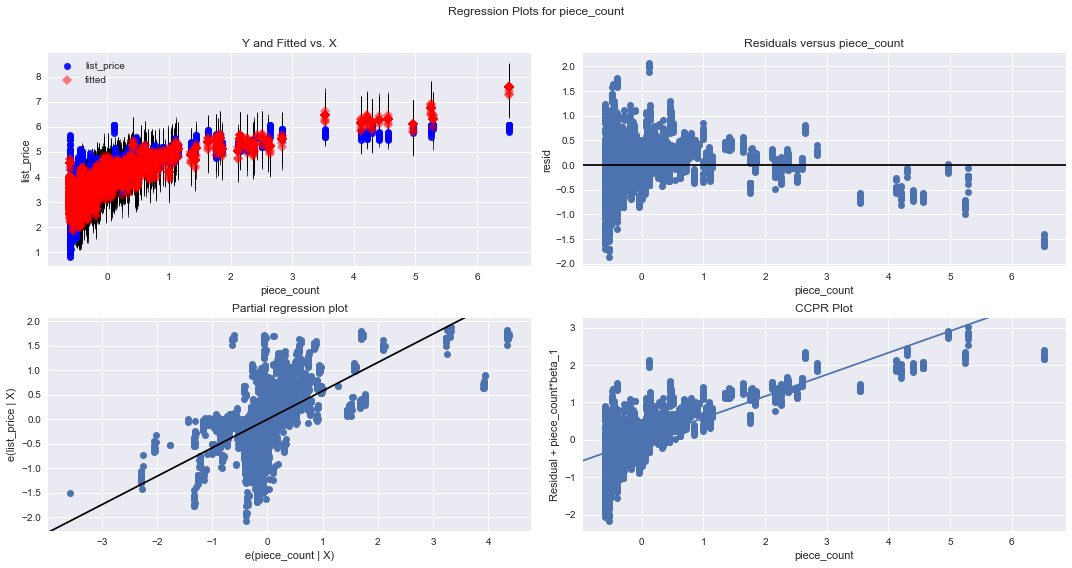

In [74]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, "piece_count", fig=fig)
plt.show()

The Y and Fitted vs. X graph plots the dependent variable against our predicted values with a confidence interval. The positive relationship shows that piece count and price are correlated, i.e., when one variable increases the other increases.

The Residuals versus height graph shows our model's errors versus the specified predictor variable. Each dot is an observed value; the line represents the mean of those observed values. Since there's no pattern in the distance between the dots and the mean value, the OLS assumption of homoskedasticity holds.

The Partial regression plot shows the relationship between piece count and price, taking in to account the impact of adding other independent variables on our existing coefficient.

The Component and Component Plus Residual (CCPR) plot is an extension of the partial regression plot. It shows where the trend line would lie after adding the impact of adding our other independent variables on the weight.